# Определение возраста покупателей

## Исследовательский анализ данных

**Описание данных**\
Данные взяты с сайта ChaLearn Looking at People. \
путь к папке: **/datasets/faces/**\
в распоряжении:
- одна папка со всеми изображениями (/final_files) -
- csv-файл labels.csv с двумя колонками: file_name и real_age.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import save_model, load_model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Загрузка данных

In [3]:
PATH = '/datasets/faces/'
PATH_FOR_FOTOS = '/datasets/faces/final_files/'

In [4]:
df_labels = pd.read_csv(PATH + 'labels.csv')
display(df_labels.head(3))
df_labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
print('Размер выборки: ', df_labels.shape)

Размер выборки:  (7591, 2)


## EDA

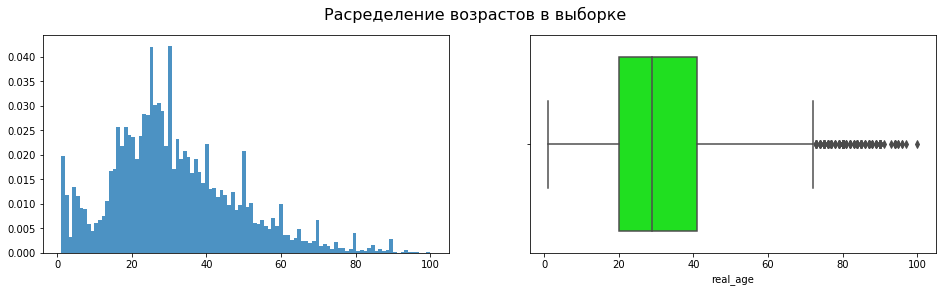

In [61]:
fig = plt.figure(figsize=(16, 4))
plt.suptitle('Расределение возрастов в выборке', fontsize=16)
fig.add_subplot(1, 2, 2)
sns.boxplot(df_labels['real_age'], color='lime')
fig.add_subplot(1, 2, 1)
plt.hist(df_labels['real_age'], density=True, bins=100, alpha=0.8)
pass

In [54]:
# plt.hist(df_labels['real_age'], density=True, bins=100)
# pass

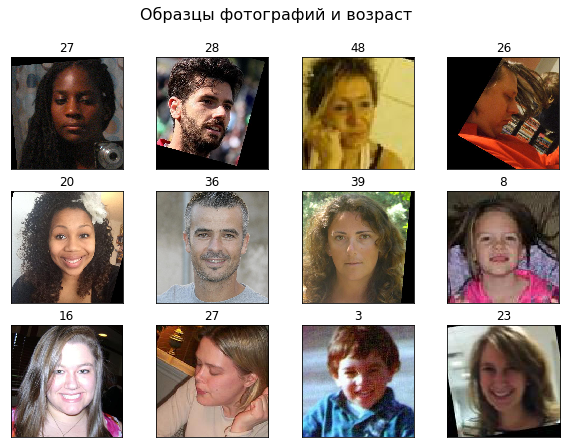

In [8]:
# выборка изображений сделана случайной
def samples_imshow():
    fig = plt.figure(figsize=(10,7))
    plt.suptitle('Образцы фотографий и возраст', fontsize=16)
    for i in range(12):
        fig.add_subplot(3, 4, i+1)
        random_index = np.random.randint(0, (df_labels.shape[0] - 1) )
        plt.imshow(Image.open(PATH_FOR_FOTOS + df_labels['file_name'].iloc[random_index]))
        plt.title(str(df_labels['real_age'].iloc[random_index]), fontsize=12)
        plt.xticks([])
        plt.yticks([])
        #plt.tight_layout()
samples_imshow()

In [9]:
image_from_jpg = Image.open(PATH + 'final_files/000000.jpg')
np.array(image_from_jpg).shape

(114, 114, 3)

# Выводы

- пропусков в данных нет
- образцы изображений: цветные размером 114x114 пикселей, отдельные кадры искажены/смазаны, фон разный, некоторые высветлены и затемнены, ориентация нормальная (голова вверху) что и ожидается на кассе.
- большинство образцов фото сосредоточены в диапазоне 20-40 лет, скорее всего потребуется аугментация для фото с возрастом менее 20 лет и возможно старше 40. 
- необходимость аугментации для диапазона выше 40 лет (и особенно старше 65 лет) это будет зависеть от задач отдела маркетинга, какие возрастные целевые группы они выделяют. 
- для возраста менее 20 лет аугментация требуется однозначно, поскольку одна из задач модели - контроль продаж алкоголя/табака лицам не достигшим 18 лет.
Конкретные методы которые планируется применять пока не описываю. Скорее всего они будут дальше.

## Обучение модели

Для аугметаций датасета решено использовать горизонтальное отражение и изменениен яркости. Исходя из предполагаемой ситуации (человек на кассе) вертикальное отражение, повороты и деформации -  исключены. Для контроля отобранные аугментации выполнены для одного изображения. В итоговом  train_datagen добавлено также смещение по горизонтали на 10%

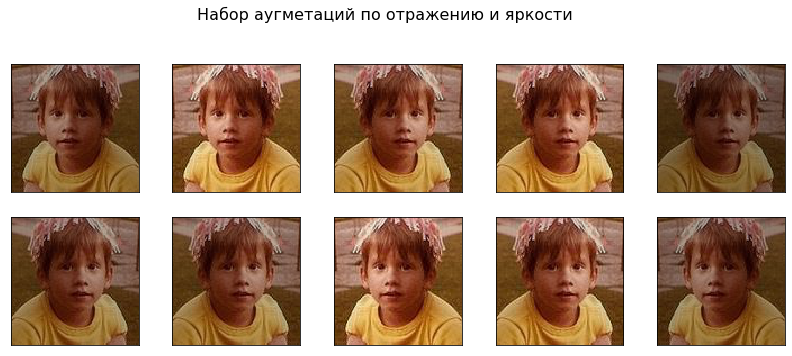

In [10]:
############################################################
# константа для диапазона яркости при аугметациях
BRIGHTNESS_RANGE = [0.5, 1.0]
############################################################

list_of_brightness = np.arange(BRIGHTNESS_RANGE[0], BRIGHTNESS_RANGE[1], 0.1)
sam = np.expand_dims(image_from_jpg, 0)
idg_brightness = ImageDataGenerator(brightness_range=BRIGHTNESS_RANGE, 
                                   horizontal_flip=True)
iterator = idg_brightness.flow(sam, batch_size=1)

fig = plt.figure(figsize=(14,8))
plt.suptitle('Набор аугметаций по отражению и яркости', fontsize=16)
for i in range(0, len(list_of_brightness)*2):
    fig.add_subplot(len(list_of_brightness)*2 // 5 + 1, 5, i+1)
    chunk = iterator.next()
    sub_img = chunk[0].astype('uint8')
    plt.imshow(sub_img)
    plt.xticks([])
    plt.yticks([])
    #plt.tight_layout()
    


```python

################################################################
### КОНСТАНТЫ
# константа для генератора случайных чисел в загрузчике
SEED = 210721
# путь к датасету
PATH = 'drive/MyDrive/datasets/faces/'
PATH_FOR_FOTOS = 'drive/MyDrive/datasets/faces/final_files/'
################################################################

train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., 
                    horizontal_flip=True,
                    vertical_flip=False,
                    brightness_range=[0.5, 1.0]
                    #rotation_range=90,
                    width_shift_range=0.1,
                    #height_shift_range=0.2
    )

validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

train_datagen_flow = train_datagen.flow_from_dataframe(
    df_labels,
    directory=PATH_FOR_FOTOS,
    x_col='file_name',
    y_col='real_age',
    weight_col=None,
    target_size=(114, 114),
    color_mode="rgb",
    class_mode="raw",
    batch_size=128,
    seed = SEED,
    shuffle=True,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset='training',
    interpolation="nearest",
    validate_filenames=True
    
)

val_datagen_flow = validation_datagen.flow_from_dataframe(
    df_labels,
    directory=PATH_FOR_FOTOS,
    x_col='file_name',
    y_col='real_age',
    weight_col=None,
    target_size=(114, 114),
    color_mode="rgb",
    class_mode="raw",
    batch_size=128,
    seed = SEED,
    shuffle=True,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset='validation',
    interpolation="nearest",
    validate_filenames=True
    
)
#####################################
### создание архитектуры модели
#####################################
def create_model(input_shape):
    
    optimizer = Adam(learning_rate=0.0005)
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    #weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    backbone.trainable = True
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, 
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])
    return model

###################################
model = create_model((114, 114, 3))

###################################
### Обучение модели
###################################
def train_model(model, train_data, test_data, epochs=1,
               steps_per_epoch=None, validation_steps=None):

       
        early_stopping =EarlyStopping(
                              monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)
        
        filepath= PATH + 'weights-improvement-{val_loss:.2f}-{epoch:02d}.hdf5'
        
        model_checkpoint = ModelCheckpoint(filepath,
                                           monitor='val_loss', 
                                           save_weights_only=True,
                                           verbose=0, 
                                           save_best_only=True, 
                                           mode='min', 
                                           #save_freq='epoch'
                                           )
       
        history = model.fit(train_data,
                validation_data=test_data,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps,
                epochs=epochs,
                verbose=2, shuffle=True,
                callbacks=[model_checkpoint]
            )

        return model, history
#############################################################################
model, history = train_model(model, train_datagen_flow, val_datagen_flow, 150)
```

```
# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
Epoch 1/100
23/23 - 1950s - loss: 17.3204 - mean_absolute_error: 17.3204 - val_loss: 55.9617 - val_mean_absolute_error: 55.9617
Epoch 2/100
23/23 - 66s - loss: 9.3284 - mean_absolute_error: 9.3284 - val_loss: 29.6162 - val_mean_absolute_error: 29.6162
Epoch 3/100
23/23 - 66s - loss: 8.0206 - mean_absolute_error: 8.0206 - val_loss: 12.9740 - val_mean_absolute_error: 12.9740
Epoch 4/100
23/23 - 67s - loss: 7.5689 - mean_absolute_error: 7.5689 - val_loss: 17.9961 - val_mean_absolute_error: 17.9961
Epoch 5/100
23/23 - 66s - loss: 6.8239 - mean_absolute_error: 6.8239 - val_loss: 16.5590 - val_mean_absolute_error: 16.5590

................

23/23 - 61s - loss: 1.7242 - mean_absolute_error: 1.7242 - val_loss: 6.5379 - val_mean_absolute_error: 6.5379
Epoch 69/100
23/23 - 61s - loss: 1.6210 - mean_absolute_error: 1.6210 - val_loss: 6.4651 - val_mean_absolute_error: 6.4651
Epoch 70/100
23/23 - 61s - loss: 1.5931 - mean_absolute_error: 1.5931 - val_loss: 6.6866 - val_mean_absolute_error: 6.6866
Epoch 71/100
23/23 - 63s - loss: 1.6053 - mean_absolute_error: 1.6053 - val_loss: 6.4632 - val_mean_absolute_error: 6.4632
Epoch 72/100
23/23 - 61s - loss: 1.5398 - mean_absolute_error: 1.5398 - val_loss: 6.5458 - val_mean_absolute_error: 6.5458
Epoch 73/100
23/23 - 61s - loss: 1.5533 - mean_absolute_error: 1.5533 - val_loss: 6.6118 - val_mean_absolute_error: 6.6118
Epoch 74/100

```

## Анализ обученной модели

**1. Лучшая достигнутая метрика MAE модели - 6.34**

2. В описанной задаче съемка людей проводится на кассе. Скорее всего человек там проведет несколько минут, кроме времени потраченного на калькуляцию товаров и расчет с кассиром возможны и очереди. Это позволит системе сделать несколько снимков и  усреднив показатели повысить точность.

3. Можно провести анализ лучших моделей с удаленных друг от друга эпох на точность в разных отрезках возрастов. Предварительно можно определить 4 кластера:
- 0-18 лет (контроль легальности продажи спиртного)
- 18-40 лет
- 40-65 лет
- 65 - и более
Очевидно что наибольшая точность нужна именно в первом кластере, поскольку "цена" ошибки там максимальна для бизнеса, как минимум это возможные штрафы. Остальные кластеры имеют больше маркетинговое значение. Для пенсионного возраста старше 65 даже большая ошибка будет иметь существенное значение для поставленных задач.\
Как итог: лучшая модель по общему MAE может быть хуже для нашей задачи чем та которая дает лучший эффект для первого кластера.

Выводы по обучению: 
- аугментации по уровню яркости дали хороший прирост точности
- модель достигает плато обучения примерно к 50 эпохе

